# Preliminaries

In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# Data
### token table

In [2]:
tokens_file = os.path.join('data', 'merged.csv')
tokens = pd.read_csv(tokens_file, dtype=str)
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,mood_cltk,tense_cltk,voice_cltk,aspect,person_cltk,number_cltk,case_cltk,gender_cltk,degree_cltk,verbform_cltk
0,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,vocative,masculine,NaN,NaN
1,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,vocative,masculine,NaN,NaN
2,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,nominative,masculine,NaN,NaN
3,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,genitive,masculine,NaN,NaN
4,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,NaN,NaN,NaN,NaN,NaN,singular,nominative,masculine,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385824,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,singular,accusative,feminine,NaN,NaN
385825,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,passive,NaN,NaN,singular,ablative,masculine,NaN,participle
385826,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
385827,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,NaN,singular,ablative,masculine,NaN,NaN


### List of mother-child pairs

In [3]:
mothers_file = os.path.join('data', 'mother-child.csv')
mothers = pd.read_csv(mothers_file, sep='\t')
display(mothers)

,spkr,addr
0,Alcimede,Jason
1,Aphrodite,Eros
2,Chalciope,Argus (son of Phrixus)
3,Chalciope,sons of Phrixus
4,Chariclo,Tiresias
...,...,...
57,Venus,Amor
58,Venus,Aeneas
59,Cybele,Jupiter
60,mother of Euryalus (son of Opheltes),Euryalus (son of Opheltes)


### Identify mother speeches

In [4]:
def motherValidation(rec):
    '''check whether any speaker-addressee combo is in the mother-child list'''
    valid_keys = list(mothers.spkr + ':' + mothers.addr)

    if rec['spkr'] is np.NaN:
        return False
    if rec['addr'] is np.NaN:
        return False
    
    for spkr in str(rec['spkr']).split(','):
        for addr in str(rec['addr']).split(','):
            key = f'{spkr}:{addr}'
            if key in valid_keys:
                return True

    return False

#### Add `mother` column

In [5]:
tokens['mother'] = tokens.apply(motherValidation, axis=1)

#### How many mother speeches?

In [6]:
tokens.groupby(['speech_id']).agg(speech_id=('speech_id', 'first'), mother=('mother', 'first')).groupby('mother').agg(count=('speech_id', 'count'))

,count
mother,
False,4025
True,97


## Hand-selected feature sets

In [7]:
excel_file = '/Users/chris/Dropbox/Epic Speeches/Listen to mummy/classification.xlsx'
lemma_class = pd.read_excel(excel_file, 'classification')

In [8]:
lem_dict = dict()

for label in lemma_class.label.unique():
    if not pd.isna(label):
        lem_dict[label] = lemma_class.loc[lemma_class.label == label, 'lemma'].values

display(lem_dict)

{'family': array(["'nate", 'altricus', 'altrix', 'avus', 'auus', 'coniunx', 'coniux',
        'filius', 'frater', 'Frater', 'fraterque', 'gemina', 'genetrix',
        'genitor', 'genus', 'infans', 'mater', 'matr', 'maternus',
        'matrisque', 'nao', 'nascor', 'Nata', 'Nate', 'natus', 'no',
        'parens', 'pario', 'partus', 'pater', 'paternus', 'patriosque',
        'patrius', 'patruum', 'pietas', 'proavum', 'progeo', 'proles',
        'puer', 'soror', 'spons', 'αἶμαι', 'ἄλοχος', 'ἀμήτωρ', 'Γάμος',
        'γάμος', 'γαστήρ', 'γεῖνος', 'γενέθλη', 'γενέθλα', 'γενετήρ',
        'γενέτης', 'γενέτη', 'γένος', 'γλάγος', 'γονεύς', 'γόνος',
        'Εἰλείθυια', 'ἐννεάκυκλος', 'θάλος', 'θυγάτηρ', 'θύγατρα',
        'κασιγνήτης', 'κόρη', 'κόρος', 'κούρη', 'κοῦρε', 'κοῦρος',
        'λοχεία', 'λοχέια', 'λοχεύω', 'λωχεύω', 'μητερός', 'μήτηρ',
        'μῆτηρ', 'μητρυιά', 'μογόστοκος', 'μόγοστοκος', 'νύμφη', 'Νύμφη',
        'νυμφίε', 'νυμφίον', 'νυμφίος', 'ὁμογάστριον', 'Παῖδες', 'Παῖδος',
  

#### Add additional classification columns

In [9]:
for tag in ['family', 'pers_poss_s', 'pers_poss_p']:
    tokens[tag] = tokens['lemma_spacy'].isin(lem_dict[tag]) | tokens['lemma_cltk'].isin(lem_dict[tag])

tokens['interrog'] = tokens['lemma_cltk'].isin(lem_dict['interrog'])

tokens['marked_verb'] = (
    (tokens['mood_cltk'] == 'imperative') | 
    (tokens['mood_spacy'] == 'Imp') | 
    (tokens['mood_spacy'] == 'Gdv') |
    ((tokens['tense_cltk'] == 'future') & (tokens['tense_spacy'] != 'Fut'))
)

In [10]:
display(tokens)

,speech_id,lang,author,work,urn,l_fi,l_la,nlines,spkr,addr,...,case_cltk,gender_cltk,degree_cltk,verbform_cltk,mother,family,pers_poss_s,pers_poss_p,interrog,marked_verb
0,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,vocative,masculine,NaN,NaN,False,False,False,False,False,False
1,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,vocative,masculine,NaN,NaN,False,False,False,False,False,False
2,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,nominative,masculine,NaN,NaN,False,False,False,False,False,False
3,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,genitive,masculine,NaN,NaN,False,False,False,False,False,False
4,1385,greek,Apollonius,Argonautica,urn:cts:greekLit:tlg0001.tlg001.perseus-grc2,1.242,1.246,5,citizens,citizens,...,nominative,masculine,NaN,NaN,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385824,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,accusative,feminine,NaN,NaN,False,False,False,False,False,False
385825,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,ablative,masculine,NaN,participle,False,False,False,False,False,False
385826,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,NaN,NaN,NaN,NaN,False,False,False,False,False,False
385827,1868,latin,Virgil,Aeneid,urn:cts:latinLit:phi0690.phi003.perseus-lat2,12.947,12.949,3,Aeneas,Turnus,...,ablative,masculine,NaN,NaN,False,False,False,False,False,False


# Analysis

In [11]:
for label, group in tokens.groupby('lang'):
    display(label, pd.crosstab(group['marked_verb'], group['mother']))

'greek'

mother,False,True
marked_verb,,
False,188637,5199
True,3605,134


'latin'

mother,False,True
marked_verb,,
False,178915,4304
True,4866,169


### log odds

In [12]:
freq_normal = tokens.loc[~tokens['mother']].groupby('lemma_spacy').size().reset_index(name='count')
freq_normal['freq'] = freq_normal['count'].div(freq_normal['count'].sum())
freq_mother = tokens.loc[tokens['mother']].groupby('lemma_spacy').size().reset_index(name='count')
freq_mother['freq'] = freq_mother['count'].div(freq_mother['count'].sum())
x = freq_normal.merge(freq_mother, on='lemma_spacy', suffixes=('_normal', '_mother'))
x['lod'] = np.log((x['freq_mother'] + 1) / (x['freq_normal'] + 1))
display(x.sort_values('lod', ascending=False)[:50])

,lemma_spacy,count_normal,freq_normal,count_mother,freq_mother,lod
8,?,2122,0.005643,116,0.011829,0.006133
1489,tu,1928,0.005127,91,0.009280,0.004123
2506,τέκνον,106,0.000282,41,0.004181,0.003891
2492,σύ,3232,0.008595,122,0.012441,0.003806
1973,καί,6285,0.016714,186,0.018968,0.002214
718,hic,2197,0.005843,79,0.008056,0.002198
2949,ἐμός,830,0.002207,43,0.004385,0.002171
902,mater,187,0.000497,25,0.002549,0.002049
2931,ἐγώ,3594,0.009558,113,0.011524,0.001945
545,ego,1984,0.005276,70,0.007138,0.001851


## rolling window of 5 lines

In [79]:
results = []
for label, group in tokens.groupby('speech_id'):
    df = group.groupby('line_id').agg(
        author = ('author', 'first'),
        work = ('work', 'first'),
        spkr = ('spkr', 'first'),
        addr = ('addr', 'first'),
        mother = ('mother', 'first'),
        tokens = ('token_spacy', 'count'),
        marked_verb = ('marked_verb', 'sum'),
        family = ('family', 'sum'),
        pers_poss_s = ('pers_poss_s', 'sum'),
        pers_poss_p = ('pers_poss_p', 'sum'),
        interrog = ('interrog', 'sum'),
    )
    results.append(
        pd.DataFrame(dict(
            speech_id = label,
            author = df['author'],
            work = df['work'],
            spkr = df['spkr'],
            addr = df['addr'],
            mother = df['mother'],
            tokens = df['tokens'].rolling(window=5, min_periods=1, center=True).sum(),
            family = df['family'].rolling(window=5, min_periods=1, center=True).sum(),
            marked_verb = df['marked_verb'].rolling(window=5, min_periods=1, center=True).sum(),
            pers_poss_s = df['pers_poss_s'].rolling(window=5, min_periods=1, center=True).sum(),
            pers_poss_p = df['pers_poss_p'].rolling(window=5, min_periods=1, center=True).sum(),
            interrog = df['interrog'].rolling(window=5, min_periods=1, center=True).sum(),
        ))
    )
results = pd.concat(results)
results['marked_verb_norm'] = results['marked_verb'].div(results['tokens'])
results['family_norm'] = results['family'].div(results['tokens'])
results['pers_poss_s_norm'] = results['pers_poss_s'].div(results['tokens'])
results['pers_poss_p_norm'] = results['pers_poss_p'].div(results['tokens'])
results['interrog_norm'] = results['interrog'].div(results['tokens'])

results['test'] = results['marked_verb'] + results['family'] + results['pers_poss_s'] + results['interrog']

### Top speeches by max composite score

In [123]:
x = results.groupby('speech_id').agg(
    author = ('author', 'first'),
    work = ('work', 'first'),
    spkr = ('spkr', 'first'),
    addr = ('addr', 'first'),
    mother = ('mother', 'first'),
    lines = ('tokens', 'count'),
    tokens = ('tokens', 'sum'),
    test_avg = ('test', 'mean'),
    test_sum = ('test', 'sum'),
    test_max = ('test', 'max'),
).sort_values('test_max', ascending=False)
display(x[:20])

,author,work,spkr,addr,mother,lines,tokens,test_avg,test_sum,test_max
speech_id,,,,,,,,,,
1758,Virgil,Aeneid,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,17,622.0,9.647059,164.0,18.0
3664,Nonnus,Dionysiaca,Artemis,Aura,False,16,486.0,8.687500,139.0,18.0
3212,Statius,Thebaid,Creon,Menoeceus,False,29,1095.0,6.931034,201.0,16.0
3369,Nonnus,Dionysiaca,Semele,Semele,False,8,223.0,9.250000,74.0,15.0
1873,Ovid,Metamorphoses,Deucalion,Pyrrha,False,16,562.0,6.625000,106.0,15.0
3324,Nonnus,Dionysiaca,Nike,Zeus,False,28,873.0,4.892857,137.0,14.0
19,Homer,Iliad,Achilles,Agamemnon,False,11,422.0,8.545455,94.0,14.0
4627,Claudian,Epithalamium de Nuptiis Honorii Augusti,Honorius,Honorius,False,27,871.0,6.111111,165.0,14.0
2685,Valerius Flaccus,Argonautica,Eidyia,Eidyia,False,27,993.0,5.592593,151.0,14.0


### Looking for the Iris-Nyx speech

In [44]:
x.loc[x['test_max']==11].sort_values('test_sum', ascending=False)

,author,work,spkr,addr,mother,lines,tokens,test_avg,test_sum,test_max
speech_id,,,,,,,,,,
2225,Ovid,Metamorphoses,Venus,Adonis,False,148,5252.0,2.722973,403.0,11.0
3382,Nonnus,Dionysiaca,Eros,Dionysus,False,126,4014.0,2.563492,323.0,11.0
4578,Claudian,De bello Gildonico,Roma,"Cybele,Jupiter,Olympian gods",False,100,3280.0,3.080000,308.0,11.0
3362,Nonnus,Dionysiaca,Semele,Zeus,False,58,1857.0,4.931034,286.0,11.0
2096,Ovid,Metamorphoses,Medea,Medea,False,61,2335.0,4.213115,257.0,11.0
2192,Ovid,Metamorphoses,Byblis,Byblis,False,46,1775.0,5.282609,243.0,11.0
3496,Nonnus,Dionysiaca,Iris-Nyx,Hypnus,True,55,1688.0,4.236364,233.0,11.0
2690,Valerius Flaccus,Argonautica,Medea,Jason,False,31,1210.0,7.290323,226.0,11.0
3134,Statius,Thebaid,Jocasta,"Argive warriors,Polynices",True,31,1165.0,6.451613,200.0,11.0


### max scores of mother speeches

In [122]:
x.loc[x['mother'] & (x['lines'] > 4)][:25]

,author,work,spkr,addr,mother,lines,tokens,test_avg,test_sum,test_max
speech_id,,,,,,,,,,
1758,Virgil,Aeneid,mother of Euryalus (son of Opheltes),"Euryalus (son of Opheltes),Jupiter,Rutulians",True,17,622.0,9.647059,164.0,18.0
582,Homer,Iliad,Hecuba,Hector,True,8,275.0,10.750000,86.0,14.0
4312,Oppian,Cynegetica,donkey,"child of donkey,donkey",True,14,411.0,7.285714,102.0,13.0
4679,Claudian,De Raptu Proserpinae,Ceres,Proserpina,True,29,1004.0,7.137931,207.0,13.0
4548,Eudocia,Homerocentones,Maria,Jesus,True,6,186.0,9.833333,59.0,13.0
4670,Claudian,De Raptu Proserpinae,Ceres,Proserpina,True,5,154.0,8.600000,43.0,12.0
3490,Nonnus,Dionysiaca,Eeria,Tectaphus,True,18,555.0,6.222222,112.0,11.0
3134,Statius,Thebaid,Jocasta,"Argive warriors,Polynices",True,31,1165.0,6.451613,200.0,11.0
3496,Nonnus,Dionysiaca,Iris-Nyx,Hypnus,True,55,1688.0,4.236364,233.0,11.0


### distribution of scores

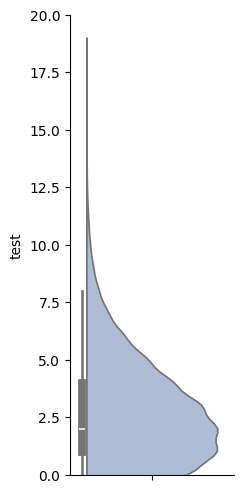

In [70]:
c = sns.light_palette('#79C')[3]
g = sns.catplot(data=results, y='test', kind="violin", bw_adjust=2, split=True, color=c)
ax = g.axes[0,0]
ax.invert_xaxis()
ax.set_ylim((-0, 20))
g.fig.set_figwidth(2)

## plot individual speeches

In [84]:
def plotSpeech(speech_id):
    mask = results['speech_id']==speech_id
    ys = results.loc[mask, 'test']

    _, l_fi = ys.index.values[0].rsplit(':', 1)
    _, l_la = ys.index.values[-1].rsplit(':', 1)
    author = results.loc[mask, 'author'].iloc[0]
    work = results.loc[mask, 'work'].iloc[0]
    title = f"{author} {work} {l_fi}-{l_la}"

    if '.' in l_fi:
        _, l_fi = l_fi.rsplit('.', 1)
    l_fi = int(l_fi)
    xs = np.arange(l_fi, l_fi+len(ys))

    avg = results['test'].mean()
    
    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(xs, ys)
    ax.axhline(avg, color=sns.light_palette('#79C')[3], ls='--')
    ax.set_ylabel('rolling composite score')
    ax.set_xlabel('line')
    ax.set_ylim((0,20))
    ax.set_title(title)
    return fig

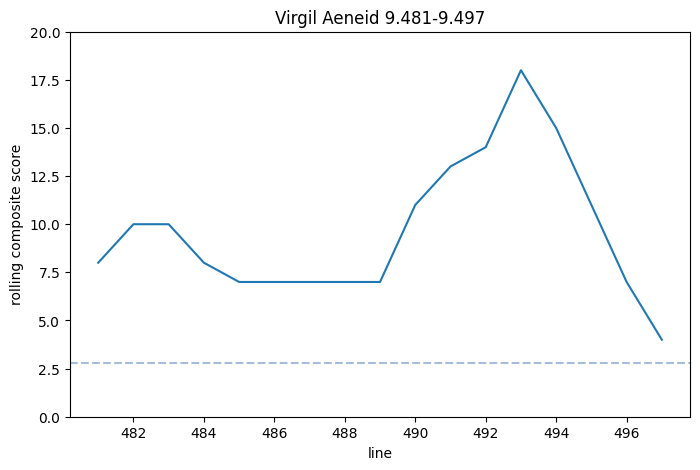

In [85]:
fig = plotSpeech('1758')
plt.show(fig)

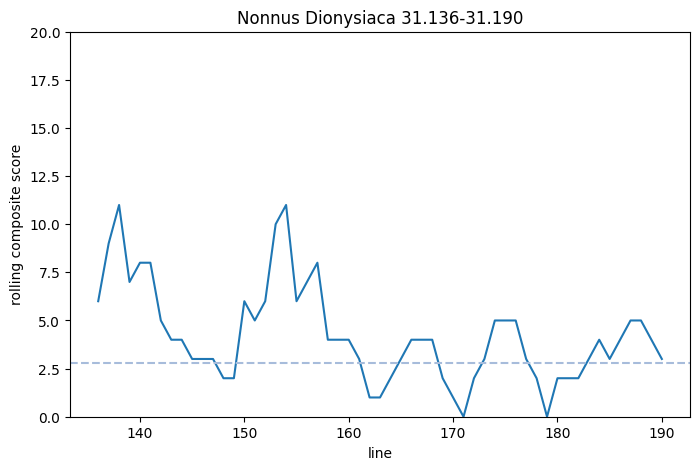

In [86]:
fig = plotSpeech('3496')
plt.show(fig)

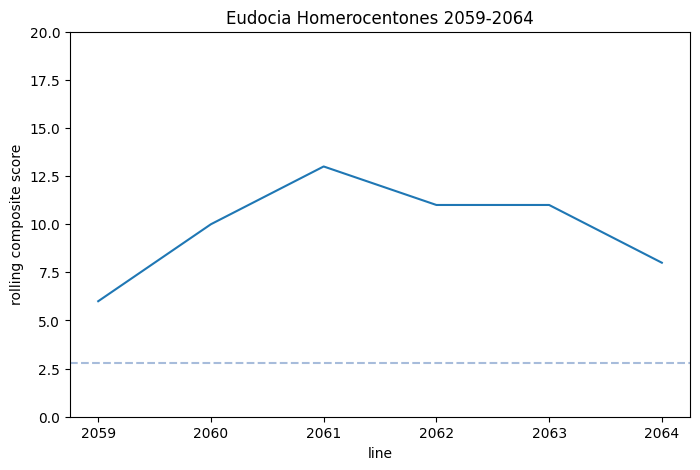

In [110]:
fig = plotSpeech('4548')
plt.show(fig)


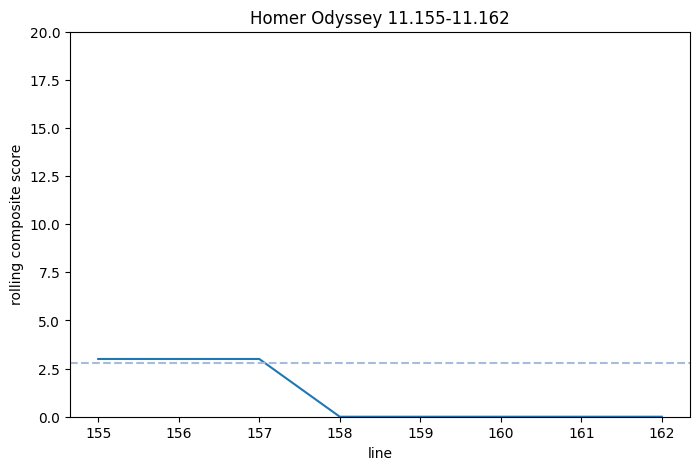

In [111]:
fig = plotSpeech('946')
plt.show(fig)

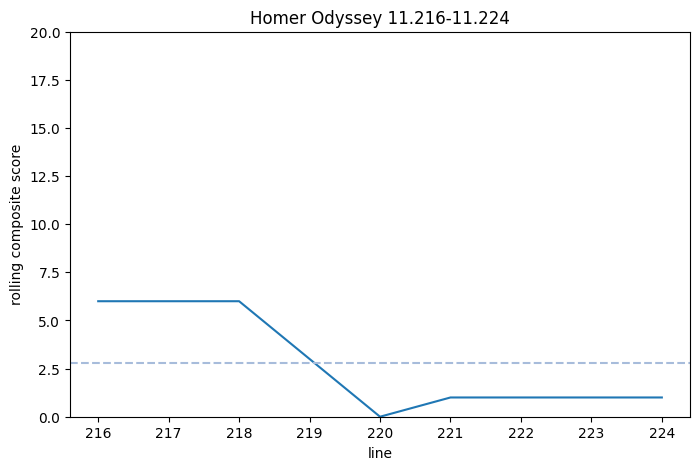

In [131]:
fig = plotSpeech('950')
plt.show(fig)

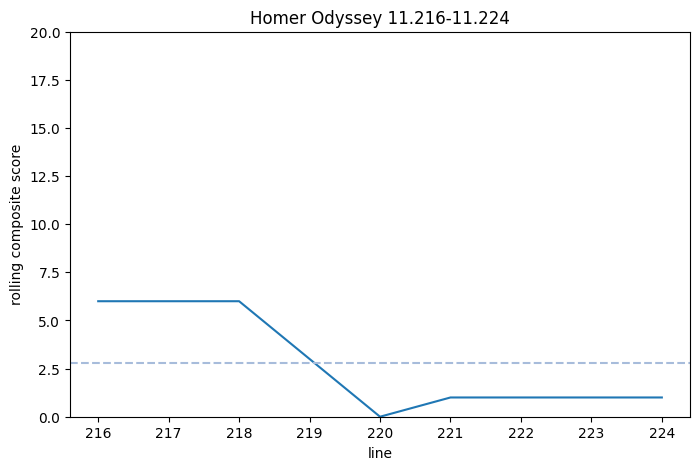

In [114]:
fig = plotSpeech('950')
plt.show(fig)

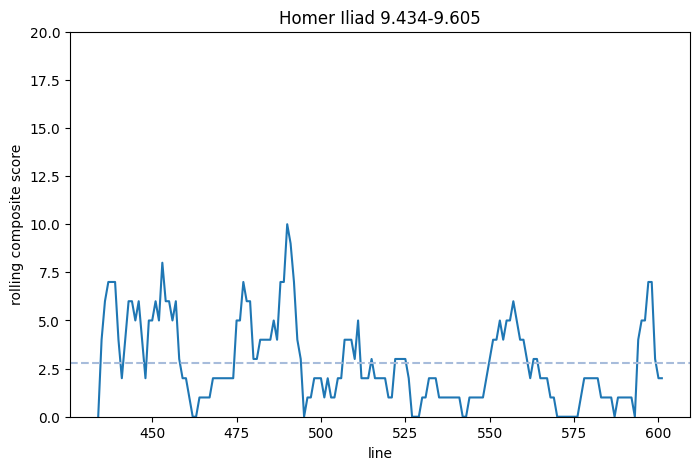

In [115]:
fig = plotSpeech('243')
plt.show(fig)

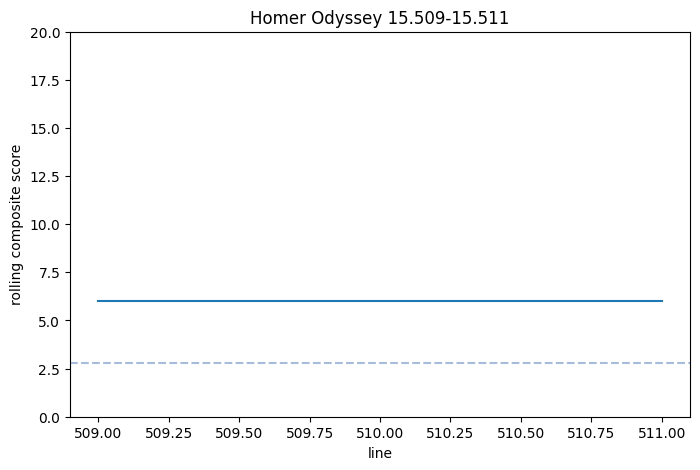

In [116]:
fig = plotSpeech('1060')
plt.show(fig)

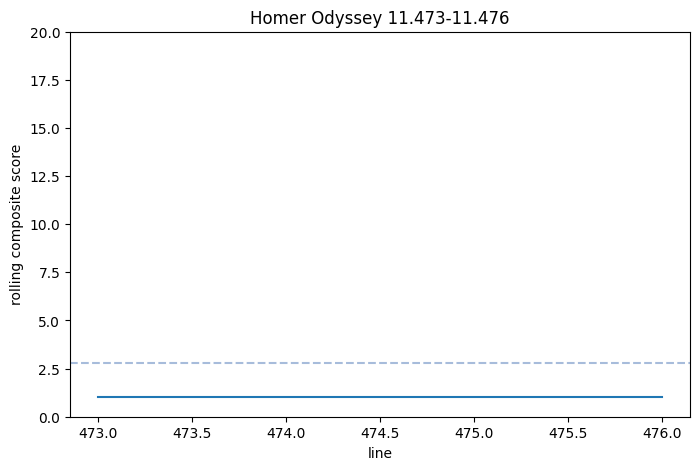

In [117]:
fig = plotSpeech('963')
plt.show(fig)

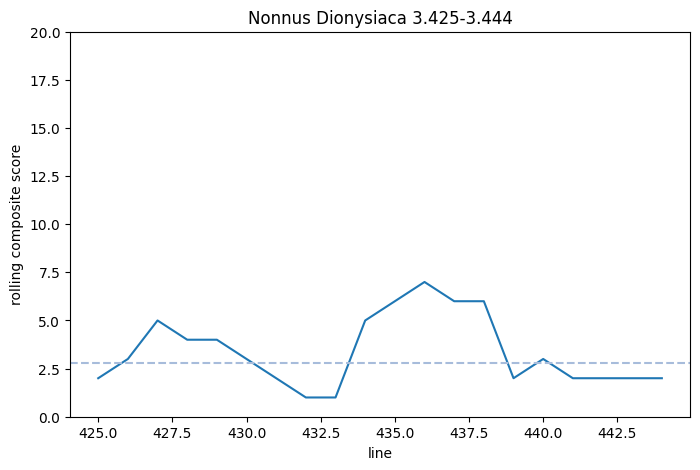

In [121]:
fig = plotSpeech('3332')
plt.show(fig)

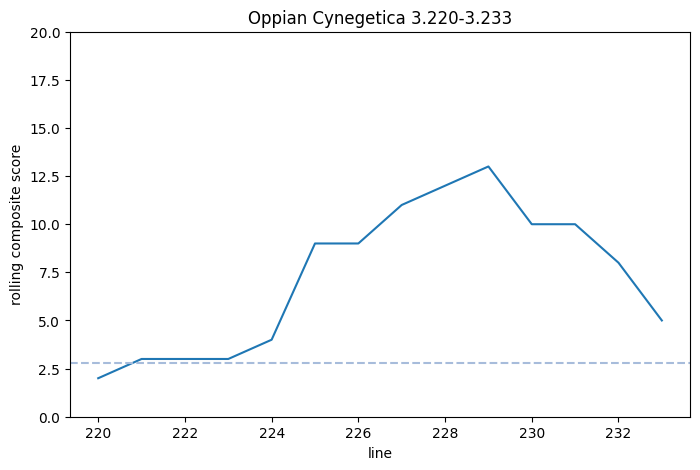

In [129]:
fig = plotSpeech('4312')
plt.show(fig)